In [114]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3

In [115]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [51]:
query = '''
 SELECT t1.id, title, CAST(avg_rating AS FLOAT64), CAST(avg_bayes_rating AS FLOAT64),
        CAST(std as FLOAT64) std, mechanic
 
 FROM TOP_GAMES_FULL t1
   LEFT JOIN BGG_MECHANICS t2
     ON t1.id = t2.id
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]

In [52]:
df = pd.DataFrame(result_li, columns = ['id', 'Title','Score', 'BayesScore', 'StdDev', 'Mechanic'])

In [53]:
# What are the top worker placement games?
df[df.Mechanic == 'Worker Placement'].head(10)

,id,Title,Score,BayesScore,StdDev,Mechanic
225,177736,feast_odin,8.19481,7.93557,1.35943,Worker Placement
240,183394,viticulture_essential_edition,8.07212,7.90471,1.26240,Worker Placement
245,164928,orleans,8.07961,7.88768,1.16433,Worker Placement
273,199792,everdell,8.10170,7.85999,1.28172,Worker Placement
286,102794,caverna_cave_farmers,8.00967,7.83646,1.34381,Worker Placement
303,31260,agricola,7.93584,7.82056,1.55505,Worker Placement
319,316554,dune_imperium,8.33742,7.81859,1.21930,Worker Placement
411,247763,underwater_cities,8.11362,7.75732,1.17854,Worker Placement
421,126163,tzolk_mayan_calendar,7.89622,7.74788,1.26793,Worker Placement
434,185343,anachrony,8.10734,7.74550,1.38137,Worker Placement


In [54]:
mechanic_popularity = pd.pivot_table(df, index='Mechanic',values='Score', aggfunc =['count','mean'])

In [55]:
mechanic_popularity.sort_values(('count', 'Score'), ascending=False, inplace=True)
mechanic_popularity.head(10)

,count,mean
,Score,Score
Mechanic,,
Hand Management,162,7.601962
Variable Player Powers,133,7.752329
Dice Rolling,127,7.647897
Card Drafting,94,7.583281
Set Collection,93,7.567719
Solo / Solitaire Game,86,7.840290
Area Majority / Influence,73,7.586709
Modular Board,64,7.663014


In [56]:
mechanic_min_30 = mechanic_popularity[mechanic_popularity[('count', 'Score')] >= 30]

In [58]:
mechanic_min_30.sort_values(('mean', 'Score'), ascending=False).head()

,count,mean
,Score,Score
Mechanic,,
Variable Set-up,41,7.878113
Scenario / Mission / Campaign Game,30,7.876293
Solo / Solitaire Game,86,7.840290
Hexagon Grid,33,7.804619
Point to Point Movement,34,7.787910


In [60]:
mechanic_min_30.sort_values(('mean', 'Score'), ascending=False).tail()

,count,mean
,Score,Score
Mechanic,,
Area Majority / Influence,73,7.586709
Card Drafting,94,7.583281
Tile Placement,56,7.572843
Set Collection,93,7.567719
Simultaneous Action Selection,34,7.560238


In [63]:
mechanic_min_30.columns

MultiIndex([('count', 'Score'),
            ( 'mean', 'Score')],
           )

In [69]:
std_pivot = pd.pivot_table(df, index='Mechanic', values =['Score'], aggfunc=['mean', 'std', 'count'])
std_pivot = std_pivot[std_pivot.index.isin(mechanic_min_30.index)]
std_pivot.sort_values(('mean', 'Score'), ascending=False)

,mean,std,count
,Score,Score,Score
Variable Set-up,7.878113,0.380549,41
Scenario / Mission / Campaign Game,7.876293,0.470028,30
Solo / Solitaire Game,7.840290,0.443947,86
Hexagon Grid,7.804619,0.487960,33
Point to Point Movement,7.787910,0.488639,34
End Game Bonuses,7.776219,0.410138,43
Worker Placement,7.755847,0.363648,63
Area Movement,7.754877,0.466624,41
Variable Player Powers,7.752329,0.455055,133


Given the lack of variability for scores, let's test to see if there is a difference between the first and last score

In [70]:
from scipy.stats import ttest_ind

In [72]:
best_mechanic = df.loc[df['Mechanic'] == 'Variable Set-up', 'Score']

In [73]:
worst_mechanic = df.loc[df['Mechanic'] == 'Simultaneous Action Selection', 'Score']

In [74]:
ttest_ind(a=best_mechanic, b=worst_mechanic,equal_var=False)

Ttest_indResult(statistic=3.0452072906670944, pvalue=0.003436278198155197)

Pretty clearly significant! Let's graph a few of them

In [75]:
# This will be a list of mechanics I like. They are not chosen for statistical purposes
mechanic_li = ['Worker Placement', 'Tile Placement', 'Solo / Solitaire Game', 'Dice Rolling', 'Set Collection']

In [77]:
five_mechanics = df[df['Mechanic'].isin(mechanic_li)]

In [78]:
import seaborn as sns

In [83]:
sns.set(rc={'figure.figsize':(10,8)})

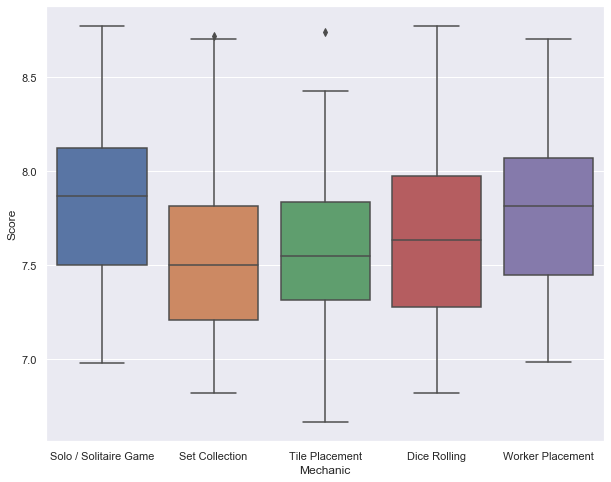

In [85]:
sns.boxplot(data=five_mechanics,x='Mechanic',y='Score')

Let's see if there's a stistically significant difference. Barplot will work for this, but we'll have a lot of wasted space since all the values are at least 7. Let's subtract 7 from all the scores

In [88]:
five_mechanics['NewScore'] = five_mechanics['Score'].apply(lambda x: x-7)

C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


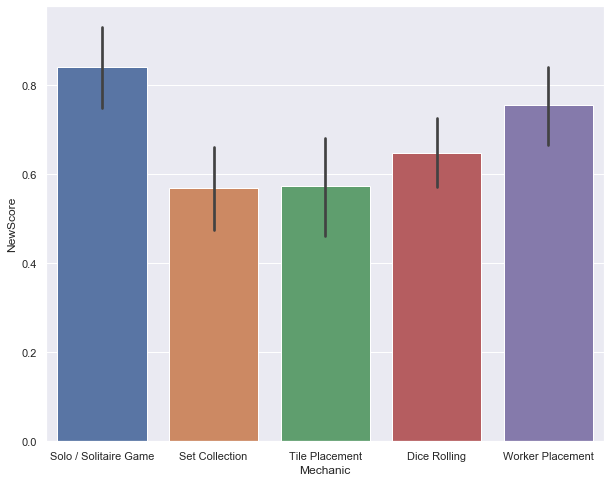

In [90]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewScore')

It looks like Solo is higher that Set Collection and Tile Placement, though there isn't a statistically significant difference between any other pair at the 5% level

Let's look at the 10% level. First, let's sort smallest to largest so it's easier to read

In [94]:
def sort_mechanic(mechanic):
    mechanic_li = ['Worker Placement', 'Tile Placement', 'Solo / Solitaire Game', 'Dice Rolling', 'Set Collection']
    if mechanic == 'Solo / Solitaire Game':
        return 0
    elif mechanic == 'Worker Placement':
        return 1
    elif mechanic == 'Dice Rolling':
        return 2
    elif mechanic == 'Tile Placement':
        return 3
    else:
        return 4

In [ ]:
five_mechanics['SortValue'] = five_mechanics['Mechanic'].apply(sort_mechanic)
five_mechanics.sort_values('SortValue',ascending=True,inplace=True)

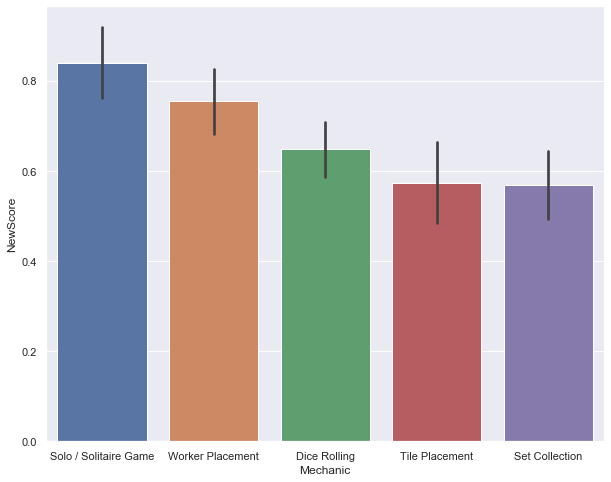

In [100]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewScore',ci=90)

Looks like solo outscores tile placement and set collection. Worker placement might also outscore them (I'm eyeballing the lines), but its close. Other than that, no two are statistically different at the 10% level.

What about the standard deviation? Are some mechanics more divisive?

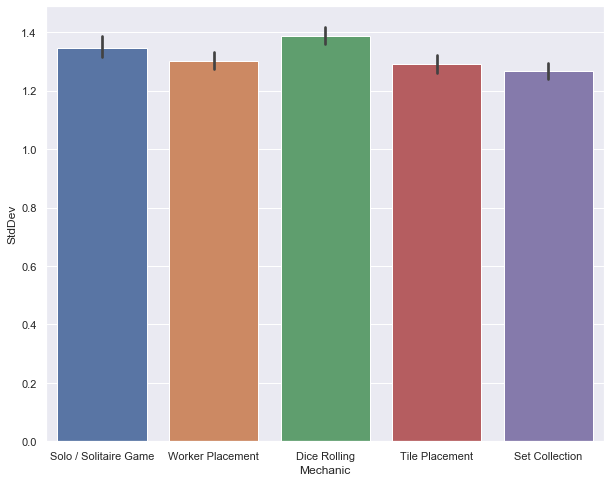

In [102]:
sns.barplot(data=five_mechanics,x='Mechanic',y='StdDev',ci=95)

Changing the axis could really change the story here. Let's subtract one from standard deviation and look again

In [104]:
# Looks like I don't need to use apply/lamba here, I wanted to try both ways
five_mechanics['NewStdDev'] = five_mechanics['StdDev'] - 1 

C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


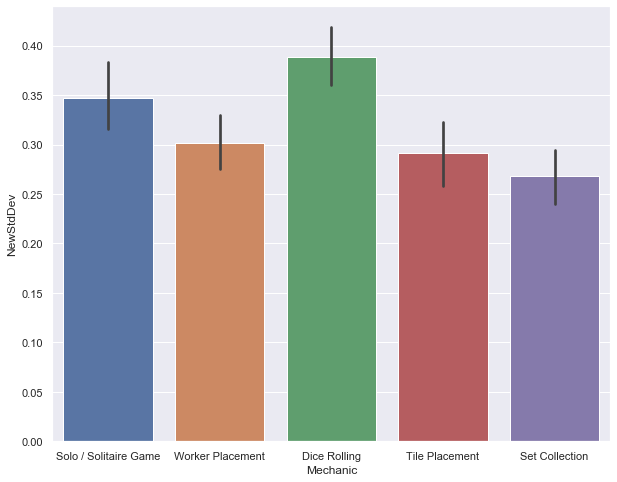

In [105]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewStdDev',ci=95)

Dice Rolling is more divisive! This makes intuitive sense to me, as it could be used in various different types of games. On the other hand, Worker Placement is generally only used in more 'hardcore' Euro games. 

...however, we have to consider the effect size. Is 0.2 points in standard deviation pratictally meaningful? Hard to say. This could be like "nudges" in behavioural economics: statistically significant but practically quite small. 